In [8]:
#import required libraries

import struct as st #This module performs conversions between Python values and C structs represented as Python bytes objects.
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow.keras as kr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

## First method to read and convert mnist dataset in idx format into python numpy array

In [2]:
# Adapted from : https://medium.com/@mannasiladittya/converting-mnist-data-in-idx-format-to-python-numpy-array-5cb9126f99f1

# Open the IDX file in readable binary mode.
filename = {'train_images' : './mnist_dataset/train-images.idx3-ubyte' ,'train_labels' : './mnist_dataset/train-labels.idx1-ubyte',
            'test_img':'./mnist_dataset/t10k-images.idx3-ubyte','test_lbl':'./mnist_dataset/t10k-labels.idx1-ubyte'}
train_imagesfile = open(filename['train_images'],'rb')
train_labelsfile = open(filename['train_labels'],'rb')
test_imagesfile = open(filename['test_img'],'rb')
test_labelsfile = open(filename['test_lbl'],'rb')


# Set pointer to the beginning of the file.
train_imagesfile.seek(0)
train_labelsfile.seek(0)
test_imagesfile.seek(0)
test_labelsfile.seek(0)

# Read the magic number
magic_img = st.unpack('>4B',train_imagesfile.read(4))
magic_lab = st.unpack('>4B',train_labelsfile.read(4))
magic_test_img = st.unpack('>4B',test_imagesfile.read(4))
magic_test_lab = st.unpack('>4B',test_labelsfile.read(4))


# Read the dimensions of the Image data-set
train_images = st.unpack('>I',train_imagesfile.read(4))[0] #num of images
n_row_i = st.unpack('>I',train_imagesfile.read(4))[0] #num of rows
n_col_i = st.unpack('>I',train_imagesfile.read(4))[0] #num of column

test_images = st.unpack('>I',test_imagesfile.read(4))[0] #num of images
n_row_test = st.unpack('>I',test_imagesfile.read(4))[0] #num of rows
n_col_test = st.unpack('>I',test_imagesfile.read(4))[0] #num of column

# Read the dimensions of the Label data-set
train_labels = st.unpack('>I',train_labelsfile.read(4))[0] #num of items
test_labels = st.unpack('>I',test_labelsfile.read(4))[0] #num of items

# Reading the Image data
train_bytes_total = train_images*n_row_i*n_col_i*1 
test_bytes_total = test_images*n_row_test*n_col_test*1 

# 'B' is used since it is of 'unsigned char' C type and ‘integer’ Python type
# and has standard size 1 as mentioned in the official documentation of struct.
# ‘>’ is used since the data is in MSB first (high endian) format used by most 
# non-Intel processors, as mentioned in their original website.
train_img = 255 - np.asarray(st.unpack('>'+'B'*train_bytes_total,train_imagesfile.read(train_bytes_total))).reshape((train_images,n_row_i,n_col_i))
test_img =   255 - np.asarray(st.unpack('>'+'B'*test_bytes_total,test_imagesfile.read(test_bytes_total))).reshape((test_images,n_row_test,n_col_test))
 
# Reading the label data
train_lbl = np.asarray(st.unpack('>'+'B'*train_labels,train_labelsfile.read(train_labels))).reshape((train_labels))
test_lbl = np.asarray(st.unpack('>'+'B'*test_labels,test_labelsfile.read(test_labels))).reshape((test_labels))

# Close read files
train_imagesfile.close()
train_labelsfile.close()
test_imagesfile.close()
test_labelsfile.close()



In [3]:
# Reshape to the expected CNN format 
train_img = train_img.reshape(train_img.shape[0], train_img.shape[1], train_img.shape[2], 1).astype('float32')
test_img = test_img.reshape(test_img.shape[0], test_img.shape[1], test_img.shape[2], 1).astype('float32')

print(test_img[132].shape)

(28, 28, 1)


5


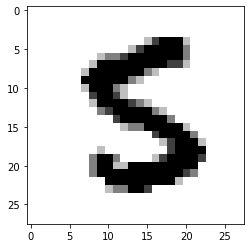

In [4]:
plt.imshow(test_img[132].reshape(28, 28), cmap='gray')

print(test_lbl[132])


## Second method to get mnist dataset into python numpy array

In [9]:
# import MNIST dataset with keras
import keras
from keras.datasets import mnist

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)# 60000 of images,sized by 28x28 pixals

(60000, 28, 28)


In [10]:
# Reshape to the expected CNN format 
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

print(x_train.shape)# 60000 images,28x28x1 

(60000, 28, 28, 1)


In [11]:
# scaling images to make gradient descent process faster
x_train=x_train/255
x_test=x_test/255

print(x_train[1].shape)

# encoding labels to categorical variables (0,1,2,3,4,5,6,7,8,9)
# adapted from : https://pbpython.com/categorical-encoding.html
y_train = kr.utils.to_categorical(y_train, 10)
y_test = kr.utils.to_categorical(y_test, 10)

print(y_train[0])


(28, 28, 1)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


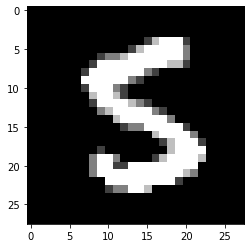

In [12]:
plt.imshow(x_test[132].reshape(28, 28), cmap='gray')

print(y_test[132])

In [9]:
# Initialising the CNN
model = Sequential()
# Convolution layer
model.add(Conv2D(32,(3,3),input_shape = (x_train.shape[1],x_train.shape[2],1),activation = 'relu'))
# Pooling as reducing feature map
model.add(MaxPooling2D(pool_size=(2, 2)))
# Apply 64 filters sized of (3x3) on 2nd convolution layer
model.add(Conv2D(64,(3, 3),activation = 'relu')) 
model.add(MaxPooling2D(pool_size=(2,2)))

# Flattening
model.add(Flatten())
# Full connection
model.add(Dense(128,activation = 'relu'))
model.add(Dense(10,activation = 'softmax'))

# Compiling of the Model
model.compile( optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=200)

# Evaluation of the model
metrics = model.evaluate(x_test, y_test, verbose=0)
print("Metrics(Test loss & Test Accuracy): ")
print(metrics)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 191s 3ms/sample - loss: 0.2632 - accuracy: 0.9235 - val_loss: 0.0726 - val_accuracy: 0.9780
Epoch 2/10
60000/60000 [==============================] - 184s 3ms/sample - loss: 0.0684 - accuracy: 0.9793 - val_loss: 0.0478 - val_accuracy: 0.9848
Epoch 3/10
60000/60000 [==============================] - 171s 3ms/sample - loss: 0.0487 - accuracy: 0.9851 - val_loss: 0.0437 - val_accuracy: 0.9850
Epoch 4/10
60000/60000 [==============================] - 174s 3ms/sample - loss: 0.0373 - accuracy: 0.9884 - val_loss: 0.0303 - val_accuracy: 0.9907
Epoch 5/10
60000/60000 [==============================] - 189s 3ms/sample - loss: 0.0291 - accuracy: 0.9909 - val_loss: 0.0362 - val_accuracy: 0.9881
Epoch 6/10
60000/60000 [==============================] - 171s 3ms/sample - loss: 0.0229 - accuracy: 0.9929 - val_loss: 0.0305 - val_accuracy: 0.9890
Epoch 7/10
60000/60000 [==========================

In [10]:
# save everything to h5 file format
model.save('./model/model.h5')





In [13]:
from tensorflow.keras.models import load_model

In [14]:

# load already compiled model
load_model = load_model('./model/model.h5')

---------------  0, 1, 2, 3, 4, 5, 6, 7, 8, 9
Actual label :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Predicted class :  [9]


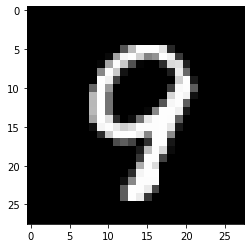

In [19]:
prd_img = load_model.predict_classes(x_test[5001].reshape(-1,28,28,1))

plt.imshow(x_test[5001].reshape(28, 28), cmap='gray')
print('---------------  0, 1, 2, 3, 4, 5, 6, 7, 8, 9',)
print('Actual label : ', y_test[5001])
print('Predicted class : ',prd_img)